In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# pip install pmdarima
from pmdarima.arima import auto_arima

In [2]:
#loads data to the dataframe doing some treatments
dateparse = lambda dates: datetime.strptime(dates, '%d/%m/%Y')
base = pd.read_csv('sales_of_papaya-faz_paraiso.csv', sep = ';', encoding= 'unicode_escape',
                   thousands = '.', decimal = ',', dtype = {'detacao': np.float64, 'empenhada': np.float64},
                   parse_dates = ['Data'], 
                   #index_col = 'Data', 
                   date_parser = dateparse,                   
                   usecols = [0, 2, 3, 5, 6, 7])
base = base.rename(columns={'Data': 'date', 'Valor por Cx.': 'price', 'Classificação': 'clas'})
base.head(5)

,date,clas,Cx.,price,Total,Cliente
0,2009-08-20,Primeira,7,25.0,175.0,Arnóbio
1,2009-08-20,Segunda,2,20.0,40.0,Arnóbio
2,2009-08-20,Birita,3,21.0,63.0,Bigão
3,2009-08-20,Redondo,4,10.0,40.0,Bigão
4,2009-08-27,Primeira,9,25.0,225.0,Arnóbio


In [3]:
#check for missing values
base.isnull().sum()
#base.isna().any()
#base.info()

date       0
clas       0
Cx.        0
price      0
Total      0
Cliente    1
dtype: int64

In [4]:
base['Cliente'].fillna('unknown', inplace = True)

In [5]:
#checks values where price equals zero
base.loc[base['price'] == 0.0] 

,date,clas,Cx.,price,Total,Cliente
404,2010-02-18,Redondo,1,0.0,0.0,Ivo
2036,2011-05-05,Maduro,27,0.0,0.0,Doação
4017,2012-08-21,Redondo,0,0.0,0.0,Aldo
4018,2012-08-21,Primeira,1,0.0,0.0,Devolvida
4460,2012-11-06,Primeira,2,0.0,0.0,Devolvidas
8073,2014-12-11,Primeira,1,0.0,0.0,Perdida
8091,2014-12-18,Primeira,2,0.0,0.0,Perdida
8092,2014-12-18,Segunda,1,0.0,0.0,Perdida
8116,2014-12-30,Primeira,10,0.0,0.0,N/S
8117,2014-12-30,Primeira,56,0.0,0.0,Voltaram


In [6]:
#excludes rows where this happens through their indexes
index_names = base.loc[base['price'] == 0.0].index
base.drop(index_names, inplace=True)

In [7]:
#filters the data only for 'Primeira' rank
base = base.loc[base['clas'] == 'Primeira'].reset_index(drop=True)
base.head(5)

,date,clas,Cx.,price,Total,Cliente
0,2009-08-20,Primeira,7,25.0,175.0,Arnóbio
1,2009-08-27,Primeira,9,25.0,225.0,Arnóbio
2,2009-08-27,Primeira,9,25.0,225.0,Raffa
3,2009-08-27,Primeira,3,27.0,81.0,Bigão
4,2009-09-01,Primeira,10,26.0,260.0,Raffa


In [8]:
#restricts the dataframe to 'Data' and 'price' only
base = base[['date','price']]
base.head()

,date,price
0,2009-08-20,25.0
1,2009-08-27,25.0
2,2009-08-27,25.0
3,2009-08-27,27.0
4,2009-09-01,26.0


In [9]:
#group values by month
#base = base.resample('M').mean()
base = base.groupby(pd.Grouper(key='date', freq='M')).mean()
base

,price
date,
2009-08-31,25.500000
2009-09-30,23.029412
2009-10-31,13.777778
2009-11-30,14.111111
2009-12-31,23.793103
...,...
2016-08-31,18.178571
2016-09-30,15.333333
2016-10-31,NaN


In [10]:
base['price'].describe()

count    81.000000
mean     19.501948
std       4.611851
min       9.503448
25%      15.471591
50%      19.966667
75%      23.029412
max      29.500000
Name: price, dtype: float64

In [11]:
#swaps the NaN values for the mean
media = base['price'].mean()
base['price'].fillna(media, inplace=True)
base

,price
date,
2009-08-31,25.500000
2009-09-30,23.029412
2009-10-31,13.777778
2009-11-30,14.111111
2009-12-31,23.793103
...,...
2016-08-31,18.178571
2016-09-30,15.333333
2016-10-31,19.501948


In [12]:
#creates the time series
ts = pd.DataFrame(base['price'])

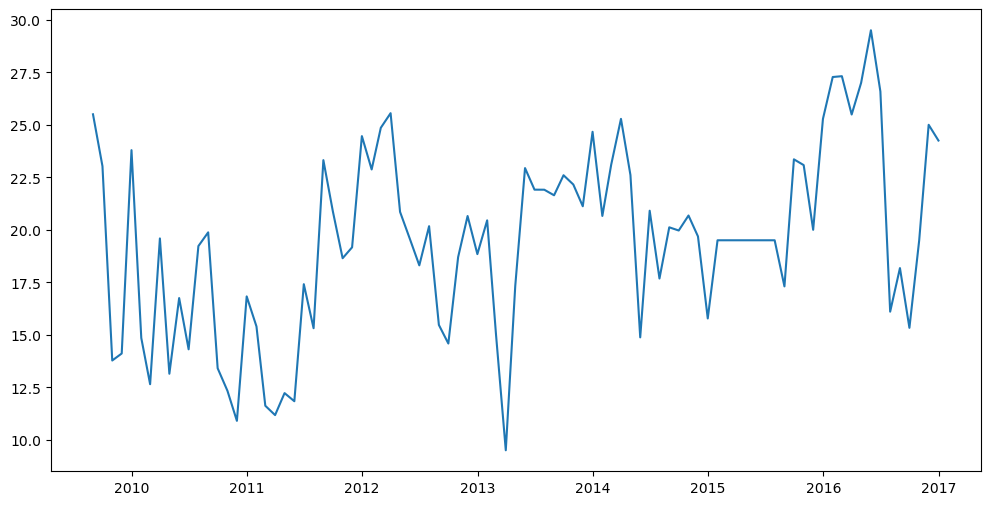

In [13]:
#views the time series
plt.figure(figsize=(12,6))
plt.plot(ts)

,price
date,
2009-12-31,20.042281
2010-12-31,15.323436
2011-12-31,16.788998
2012-12-31,20.037237
2013-12-31,20.103714
2014-12-31,20.112770
2015-12-31,20.461408
2016-12-31,23.460932


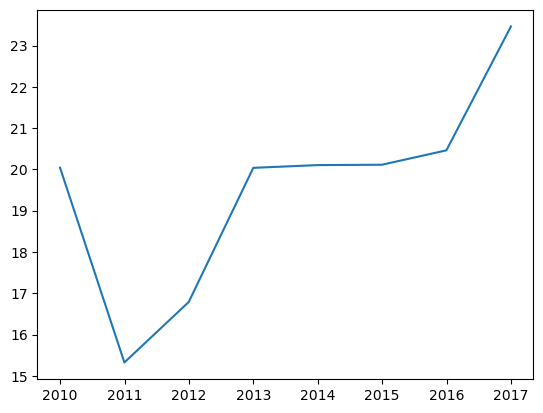

In [14]:
#Views by year
ts_year = ts.resample('A').mean()
plt.plot(ts_year)
ts_year

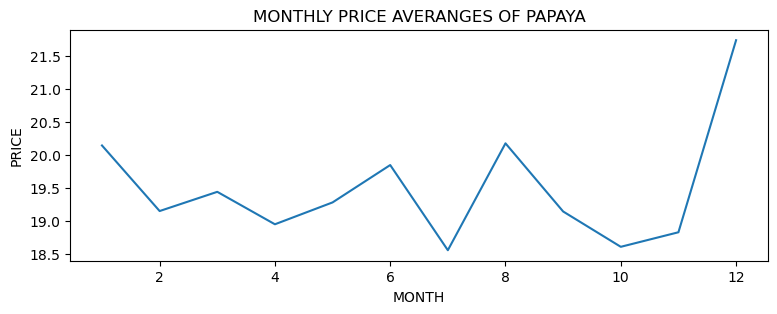

In [15]:
#views the behavior of the time series in terms of year
plt.figure(figsize=(9,3))
plt.xlabel('MONTH')
plt.ylabel('PRICE')
plt.title('MONTHLY PRICE AVERANGES OF PAPAYA')
ts_month = ts.groupby([lambda x: x.month]).mean()
plt.plot(ts_month)

In [ ]:
# Although the time interval of this time series is short and presents missing data that were filled in with averages, 
# the series can help us understand that the best prices to sell papaya are the months of August and December, 
# helping the investor to make a decision who wants to focus on greater production for these months.

In [16]:
#Decomposes the time series
decompose = seasonal_decompose(ts)

In [25]:
trend = decompose.trend
trend.head(10)

date
2009-08-31          NaN
2009-09-30          NaN
2009-10-31          NaN
2009-11-30          NaN
2009-12-31          NaN
2010-01-31          NaN
2010-02-28    17.326981
2010-03-31    16.691921
2010-04-30    16.230997
2010-05-31    16.037309
Freq: M, Name: trend, dtype: float64

In [34]:
season = decompose.seasonal
season

date
2009-08-31    0.394981
2009-09-30   -0.237560
2009-10-31   -0.240724
2009-11-30   -1.103645
2009-12-31    1.110479
                ...   
2016-08-31    0.394981
2016-09-30   -0.237560
2016-10-31   -0.240724
2016-11-30   -1.103645
2016-12-31    1.110479
Freq: M, Name: seasonal, Length: 89, dtype: float64

In [24]:
aleatory = decompose.resid
aleatory

date
2009-08-31   NaN
2009-09-30   NaN
2009-10-31   NaN
2009-11-30   NaN
2009-12-31   NaN
              ..
2016-08-31   NaN
2016-09-30   NaN
2016-10-31   NaN
2016-11-30   NaN
2016-12-31   NaN
Freq: M, Name: resid, Length: 89, dtype: float64

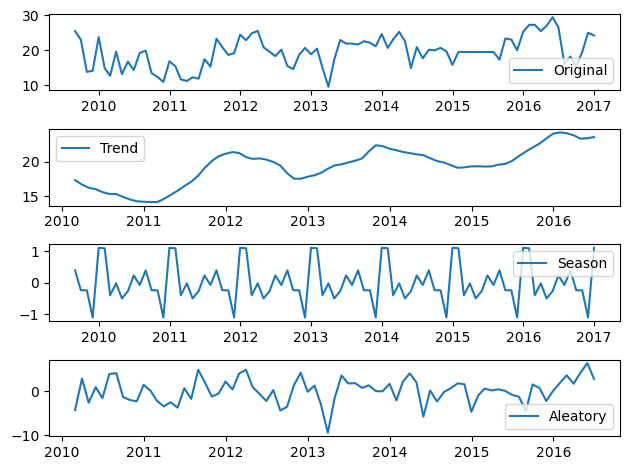

In [38]:
plt.subplot(4,1,1)
plt.plot(ts, label = 'Original')
plt.legend(loc = 'best')

plt.subplot(4,1,2)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')

plt.subplot(4,1,3)
plt.plot(season, label = 'Season')
plt.legend(loc = 'best')

plt.subplot(4,1,4)
plt.plot(aleatory, label = 'Aleatory')
plt.legend(loc = 'best')
plt.tight_layout()

In [53]:
#Time series forecasting
stepwise_model = auto_arima(ts, start_p=1,start_q=1,start_d=0, start_P=0, 
                            max_p=6, max_q=6, m=12, seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=493.667, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=491.015, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=486.511, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=491.668, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=486.102, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=486.080, Time=0.06 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=486.923, Time=0.14 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=486.422, Time=0.14 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=488.420, Time=0.30 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=492.419, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=484.09

In [54]:
stepwise_model.aic()

476.0391512405594

In [55]:
#Separate training and testing data
train = ts.loc['2009-08-31':'2015-12-31']
test = ts.loc['2016-01-01':]

In [56]:
train

,price
date,
2009-08-31,25.500000
2009-09-30,23.029412
2009-10-31,13.777778
2009-11-30,14.111111
2009-12-31,23.793103
...,...
2015-08-31,17.306250
2015-09-30,23.355932
2015-10-31,23.081081


In [57]:
test

,price
date,
2016-01-31,27.275000
2016-02-29,27.313725
2016-03-31,25.489796
2016-04-30,27.000000
2016-05-31,29.500000
2016-06-30,26.585366
2016-07-31,16.103448
2016-08-31,18.178571
2016-09-30,15.333333


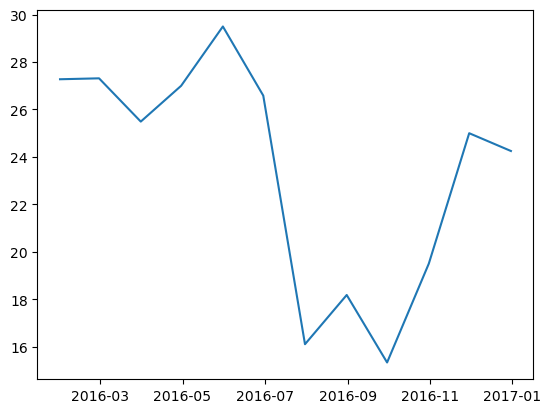

In [61]:
plt.plot(test)

In [58]:
#Trains the model with data
stepwise_model.fit(train)

ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [59]:
#Makes a forecast for 12 months
future_forecast = stepwise_model.predict(n_periods=12)

In [47]:
future_forecast

2016-01-31    22.126814
2016-02-29    21.724440
2016-03-31    22.374772
2016-04-30    21.577603
2016-05-31    19.275217
2016-06-30    21.071702
2016-07-31    20.110199
2016-08-31    21.220901
2016-09-30    20.115897
2016-10-31    20.376815
2016-11-30    20.619986
2016-12-31    18.531560
Freq: M, dtype: float64

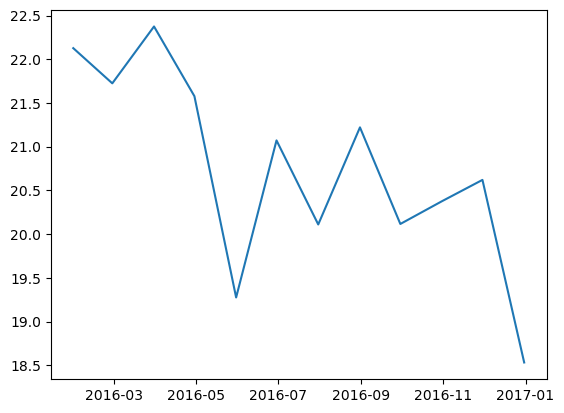

In [60]:
plt.plot(future_forecast)

In [62]:
#Creates a dataframe to compare the forecast
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['price'])

<AxesSubplot:xlabel='date'>

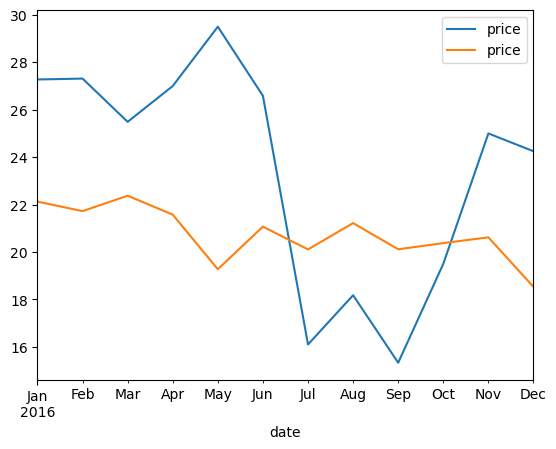

In [63]:
pd.concat([test,future_forecast],axis=1).plot()

In [ ]:
#forecast in orange

<AxesSubplot:xlabel='date'>

<Figure size 1200x600 with 0 Axes>

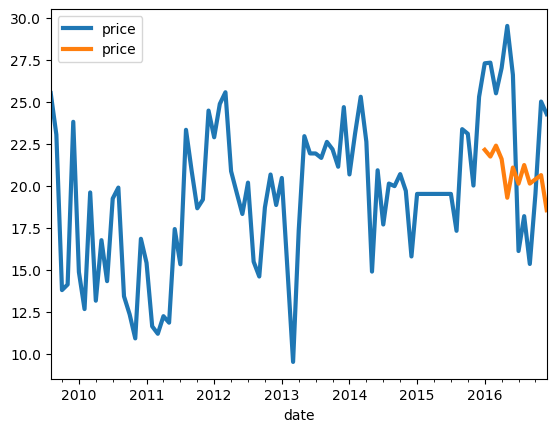

In [69]:
plt.figure(figsize=(12,6))
pd.concat([ts,future_forecast],axis=1).plot(linewidth=3)